# Investigando algo genético para planear torneos *Double Round Robin*

En torneos Double Round Robin todos los equipos se enfrentan 2 veces, una vez en casa y otra de visita.

Como conocemos todas las partidas de antemano, la planeación de un torneo se reduce a ordenar las partidas de una forma válida/óptima. Para que una asignacion sea valida cada equipo debe jugar exactamente una vez por jornada.

Si hay $n$ equipos, hay
- $n(n-1)$ juegos en el torneo
- $n/2$ juegos por jornada
- y $2(n-1)$ jornadas.

Representamos una partida con la pareja $(X,Y)$, que indica que juega $X$ vs. $Y$ en casa de $X$.

Codigo en inglés. Jornada->week.

In [1]:
import numpy as np
import random,time,json
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
# Given the number of teams, returns the list of games that must be played
def games(nTeams):
    games=[]
    for i in range(1,nTeams+1):
        for j in range(1,nTeams+1):
            if i==j:continue
            games.append((i,j))
    assert len(games)==nTeams*(nTeams-1)
    return games

In [3]:
# Returns a random assignment/tournament by shuffling the list of games
def randomAssignment(nTeams):
    p=games(nTeams)
    random.shuffle(p)
    return p

In [4]:
# Returns a random assignment of teams to cities
def randomCityTeams(nTeams,nCities):
    cities={i:[] for i in range(1,nCities+1)} # city:[team1,team2]
    randTeams=list(range(1,nTeams+1))
    random.shuffle(randTeams)
    while len(randTeams)>0:
        city=random.choice(range(1,nCities+1))
        cities[city].append(randTeams.pop())
    return cities

In [5]:
# Given a cityTeams dict (city:[list of teams]), returns a dict (team:city)
def teamToCity(cityTeams):
    out={}
    for city,teams in cityTeams.items():
        for team in teams:
            out[team]=city
    return out

In [6]:
def randomCityDistances(nCities,low=0,high=100):
    r=np.random.randint(low,high,size=(nCities,nCities))
    return (r+r.T)/2

In [7]:
randomCityDistances(4)

array([[51. , 75.5, 51.5, 12.5],
       [75.5, 56. , 44.5, 62.5],
       [51.5, 44.5, 91. , 50. ],
       [12.5, 62.5, 50. , 10. ]])

In [8]:
randomCityTeams(4,3)

{1: [1, 3], 2: [2], 3: [4]}

In [9]:
randomAssignment(4)

[(3, 4),
 (2, 4),
 (4, 1),
 (2, 3),
 (4, 2),
 (2, 1),
 (3, 2),
 (4, 3),
 (1, 4),
 (1, 2),
 (1, 3),
 (3, 1)]

In [10]:
def lastWeek(assignment,nTeams):
    week=[]
    for i in range(0,len(assignment),nTeams//2):
        week=assignment[i:i+nTeams//2]
    return week

In [11]:
def approx(nTeams):
    current=[]
    gs=games(nTeams)
    remaining=gs[:]
    random.shuffle(remaining)
    week=[]
    while len(current)!=nTeams*(nTeams-1):
        available=[]
        for game in remaining:
            if game[0] not in week and game[1] not in week:
                available.append(game)
        game=random.choice(available) if available else remaining.pop()
        current.append(game)
        week.append(game)
        week=week[-nTeams//2:]
        remaining.remove(game)
    assert len(set(current))==nTeams*(nTeams-1)
    return current   

In [12]:
approx(4)

[(3, 4),
 (2, 4),
 (2, 1),
 (1, 4),
 (4, 3),
 (2, 3),
 (4, 2),
 (3, 2),
 (1, 3),
 (1, 2),
 (4, 1),
 (3, 1)]

In [13]:
def approxAssignment(nTeams):
    current=[]
    gs=games(nTeams)
    remaining=gs[:]
    while len(current)!=nTeams*(nTeams-1):
        available=[]
        inLastWeek=teamsInGames(lastWeek(current,nTeams))
        for game in remaining:
            if game[0] not in inLastWeek and game[1] not in inLastWeek:
                available.append(game)
        game=random.choice(available) if available else random.choice(remaining)
        current.append(game)
        remaining.remove(game)
    assert len(set(current))==nTeams*(nTeams-1)
    return current

In [14]:
# Used in conflicts(). Given a list of len 2 tuples, returns a list with all elements.
def teamsInGames(week):
    out=[]
    for game in week:
        out.append(game[0])
        out.append(game[1])
    return out

In [51]:
# Returns the conflicts in an assignment/tournament.
# Marks as 1 games in which a participating team plays more than once in that week.
def conflicts(assignment,nTeams):
    conflicts=[]
    n=nTeams 
    for i in range(0,len(assignment),n//2):
        week=assignment[i:i+n//2]
        #print(week)
        teamsInWeek=teamsInGames(week)
        for game in week:
            conflicts.append(0)
            if assignment.count(game)!=1:
                conflicts[-1]=1
            else:
                for team in game:
                    if teamsInWeek.count(team)!=1:
                        conflicts[-1]=1
    return conflicts

In [69]:
# Returns the conflicts in an assignment/tournament.
# Marks as 1 games in which a participating team plays more than once in that week.
def nConflicts2(assignment,nTeams):
    conflicts=0
    n=nTeams 
    weeks=0
    for i in range(0,len(assignment),n//2):
        weeks+=1
        week=assignment[i:i+n//2]
        teamsInWeek=teamsInGames(week)
        assert len(teamsInWeek)==nTeams
        c=nTeams-len(set(teamsInWeek))
        print(week,c)
        conflicts+=c/(n/2)
    assert weeks==2*(n-1)
    assert len(assignment)==n*(n-1)
    print(len(assignment)-len(set(assignment)))
    return conflicts/weeks +(len(assignment)-len(set(assignment)))/len(assignment)

In [87]:
nConflicts2([[4,3],[1,2],[3,1],[2,4],[4,2],[1,3],[2,1],[3,4],[3,2],[4,1],[2,3],[1,4]],4)

[[4, 3], [1, 2]] 0
[[3, 1], [2, 4]] 0
[[4, 2], [1, 3]] 0
[[2, 1], [3, 4]] 0
[[3, 2], [4, 1]] 0
[[2, 3], [1, 4]] 0


TypeError: unhashable type: 'list'

In [77]:
conflicts(p,6)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [79]:
p=approxAssignment(6)
p=freeMutate(p,6)
print(p)
nConflicts2(p,6)

[(2, 1), (3, 4), (5, 6), (3, 2), (5, 6), (6, 5), (2, 3), (4, 6), (1, 5), (6, 2), (5, 4), (1, 3), (4, 3), (2, 5), (1, 6), (1, 2), (3, 5), (6, 4), (3, 6), (5, 1), (2, 4), (1, 4), (5, 2), (6, 3), (6, 1), (5, 3), (4, 2), (2, 6), (4, 5), (3, 1)]
[(2, 1), (3, 4), (5, 6)] 0
[(3, 2), (5, 6), (6, 5)] 2
[(2, 3), (4, 6), (1, 5)] 0
[(6, 2), (5, 4), (1, 3)] 0
[(4, 3), (2, 5), (1, 6)] 0
[(1, 2), (3, 5), (6, 4)] 0
[(3, 6), (5, 1), (2, 4)] 0
[(1, 4), (5, 2), (6, 3)] 0
[(6, 1), (5, 3), (4, 2)] 0
[(2, 6), (4, 5), (3, 1)] 0
1


0.1

In [84]:
a=[]
for _ in range(1000):
    p=approxAssignment(8)
    if random.random()<0.25:
        p=freeMutate(p,8)
    if random.random()<0.25:
        p=freeMutate(p,8)
    a.append(nConflicts2(p,8))

[(1, 2), (4, 8), (7, 3), (5, 6)] 0
[(8, 2), (3, 5), (3, 6), (5, 7)] 2
[(4, 6), (3, 5), (2, 7), (1, 8)] 0
[(2, 5), (8, 2), (1, 3), (7, 8)] 2
[(1, 4), (5, 3), (6, 2), (8, 7)] 0
[(1, 6), (3, 4), (7, 5), (2, 8)] 0
[(7, 4), (3, 1), (5, 2), (6, 8)] 0
[(6, 5), (8, 3), (7, 2), (8, 1)] 1
[(2, 4), (8, 6), (5, 1), (3, 7)] 0
[(2, 3), (8, 4), (7, 1), (4, 5)] 1
[(1, 7), (8, 5), (3, 2), (3, 8)] 2
[(1, 5), (6, 7), (4, 3), (5, 4)] 2
[(2, 6), (4, 7), (5, 8), (4, 2)] 2
[(6, 1), (2, 1), (7, 6), (6, 3)] 3
2
[(3, 2), (8, 7), (1, 6), (4, 5)] 0
[(6, 4), (1, 7), (5, 2), (8, 3)] 0
[(2, 3), (8, 4), (6, 7), (5, 1)] 0
[(2, 1), (3, 6), (7, 8), (5, 4)] 0
[(1, 3), (4, 6), (5, 8), (7, 2)] 0
[(3, 1), (7, 4), (6, 5), (2, 8)] 0
[(8, 5), (6, 3), (4, 2), (7, 1)] 0
[(5, 7), (2, 4), (8, 6), (4, 6)] 2
[(1, 2), (7, 5), (3, 8), (4, 8)] 1
[(7, 6), (8, 2), (5, 3), (1, 4)] 0
[(1, 8), (3, 5), (4, 7), (2, 6)] 0
[(4, 1), (5, 6), (2, 7), (3, 7)] 1
[(6, 2), (7, 3), (8, 1), (6, 8)] 2
[(1, 5), (4, 3), (2, 5), (6, 1)] 2
1
[(5, 6), (8, 3),

[(5, 7), (1, 4), (2, 6), (8, 3)] 0
[(2, 5), (1, 7), (6, 8), (3, 4)] 0
[(7, 8), (3, 6), (5, 2), (4, 1)] 0
[(6, 2), (7, 1), (3, 5), (8, 4)] 0
[(7, 6), (1, 5), (4, 8), (2, 3)] 0
[(8, 6), (1, 2), (1, 2), (4, 3)] 2
[(1, 8), (2, 4), (7, 3), (6, 5)] 0
[(5, 3), (2, 1), (4, 7), (7, 2)] 2
[(4, 5), (3, 1), (2, 7), (8, 5)] 1
[(2, 8), (5, 4), (1, 6), (3, 7)] 0
[(4, 6), (5, 1), (8, 2), (1, 3)] 1
[(3, 8), (5, 6), (4, 2), (7, 4)] 1
[(6, 1), (8, 7), (3, 2), (6, 7)] 2
[(5, 8), (6, 4), (8, 1), (6, 3)] 2
1
[(5, 3), (2, 4), (8, 6), (7, 1)] 0
[(2, 5), (1, 8), (7, 4), (6, 3)] 0
[(1, 2), (6, 5), (5, 2), (3, 7)] 2
[(3, 1), (7, 8), (2, 6), (5, 4)] 0
[(7, 3), (4, 5), (1, 6), (2, 8)] 0
[(8, 1), (2, 3), (6, 7), (1, 7)] 2
[(1, 4), (3, 6), (5, 8), (7, 2)] 0
[(8, 7), (4, 6), (3, 2), (5, 1)] 0
[(5, 2), (8, 3), (4, 1), (7, 6)] 0
[(1, 5), (6, 4), (3, 8), (2, 7)] 0
[(4, 3), (6, 2), (8, 5), (5, 6)] 2
[(6, 1), (7, 5), (4, 8), (4, 7)] 2
[(3, 4), (2, 1), (6, 8), (5, 7)] 0
[(3, 5), (8, 2), (4, 2), (1, 3)] 2
1
[(3, 8), (5, 6),

[(8, 5), (3, 2), (6, 1), (7, 4)] 0
[(8, 7), (4, 2), (6, 5), (3, 1)] 0
[(7, 6), (5, 8), (1, 2), (3, 4)] 0
[(1, 3), (2, 5), (4, 7), (8, 6)] 0
[(8, 1), (2, 7), (5, 6), (3, 7)] 1
[(3, 8), (4, 1), (6, 2), (5, 7)] 0
[(4, 8), (2, 3), (5, 1), (1, 7)] 1
[(8, 3), (2, 4), (7, 5), (1, 6)] 0
[(5, 2), (1, 8), (6, 4), (7, 3)] 0
[(6, 8), (3, 5), (1, 4), (7, 2)] 0
[(6, 3), (2, 8), (5, 4), (4, 6)] 2
0
[(1, 7), (6, 5), (8, 4), (2, 3)] 0
[(4, 8), (7, 3), (1, 6), (5, 2)] 0
[(3, 6), (2, 4), (8, 7), (5, 1)] 0
[(3, 5), (2, 8), (4, 7), (6, 1)] 0
[(1, 4), (7, 6), (8, 2), (5, 3)] 0
[(1, 8), (2, 7), (6, 4), (1, 2)] 2
[(7, 1), (4, 5), (8, 6), (3, 2)] 0
[(4, 1), (8, 5), (3, 7), (2, 6)] 0
[(3, 4), (2, 1), (7, 5), (6, 8)] 0
[(3, 1), (6, 2), (5, 7), (5, 4)] 1
[(6, 7), (1, 5), (4, 2), (8, 3)] 0
[(2, 5), (8, 1), (4, 6), (3, 8)] 1
[(7, 2), (1, 3), (5, 6), (6, 3)] 2
[(7, 8), (4, 3), (5, 8), (7, 4)] 3
0
[(1, 2), (4, 3), (5, 6), (8, 7)] 0
[(3, 8), (1, 5), (6, 2), (4, 7)] 0
[(2, 7), (3, 4), (5, 1), (6, 8)] 0
[(2, 5), (7, 3),

[(4, 6), (5, 7), (2, 3), (1, 8)] 0
[(2, 1), (6, 8), (3, 7), (4, 5)] 0
[(7, 6), (4, 1), (5, 3), (2, 8)] 0
[(3, 2), (1, 5), (6, 4), (7, 8)] 0
[(8, 7), (2, 4), (6, 3), (5, 1)] 0
[(3, 8), (7, 5), (6, 1), (4, 2)] 0
[(6, 7), (4, 8), (2, 5), (1, 3)] 0
[(1, 4), (8, 2), (3, 5), (2, 7)] 1
[(5, 4), (7, 1), (2, 6), (8, 3)] 0
[(8, 6), (3, 1), (7, 2), (3, 4)] 1
[(6, 5), (7, 3), (8, 4), (1, 2)] 0
[(1, 6), (8, 5), (7, 4), (5, 6)] 2
0
[(8, 4), (7, 5), (2, 1), (6, 3)] 0
[(6, 7), (8, 2), (5, 1), (4, 3)] 0
[(2, 8), (3, 7), (1, 6), (4, 5)] 0
[(5, 7), (8, 3), (2, 4), (6, 1)] 0
[(5, 6), (4, 8), (3, 1), (2, 7)] 0
[(6, 8), (1, 5), (7, 4), (3, 2)] 0
[(4, 7), (6, 2), (3, 8), (5, 4)] 1
[(4, 2), (7, 1), (8, 5), (3, 6)] 0
[(1, 2), (5, 3), (4, 6), (7, 8)] 0
[(5, 2), (1, 3), (6, 4), (8, 7)] 0
[(2, 6), (1, 8), (7, 3), (2, 5)] 1
[(8, 6), (2, 3), (4, 1), (7, 2)] 1
[(8, 1), (6, 5), (3, 4), (1, 7)] 1
[(3, 5), (7, 6), (1, 4), (5, 8)] 1
0
[(3, 2), (5, 6), (7, 1), (4, 8)] 0
[(4, 7), (1, 6), (8, 5), (2, 3)] 0
[(7, 8), (6, 2),

[(2, 7), (8, 4), (6, 5), (1, 3)] 0
[(2, 4), (6, 1), (5, 7), (3, 8)] 0
[(4, 7), (3, 2), (1, 6), (8, 5)] 0
[(8, 3), (7, 2), (5, 6), (4, 1)] 0
[(3, 6), (8, 7), (1, 5), (4, 5)] 1
[(5, 2), (8, 1), (7, 4), (2, 3)] 1
[(6, 2), (3, 5), (1, 7), (4, 8)] 0
[(7, 1), (2, 5), (8, 6), (4, 3)] 0
[(6, 4), (1, 2), (3, 7), (6, 8)] 1
1
[(2, 3), (5, 7), (6, 8), (1, 4)] 0
[(6, 3), (8, 2), (4, 1), (7, 5)] 0
[(5, 1), (4, 2), (7, 6), (8, 3)] 0
[(8, 6), (5, 2), (4, 7), (3, 1)] 0
[(1, 6), (2, 3), (2, 5), (4, 3)] 2
[(5, 4), (6, 1), (3, 8), (2, 7)] 0
[(2, 6), (3, 5), (7, 4), (1, 8)] 0
[(3, 6), (8, 4), (1, 7), (7, 2)] 1
[(5, 8), (6, 7), (3, 4), (2, 1)] 0
[(7, 8), (3, 2), (4, 6), (1, 5)] 0
[(7, 3), (4, 5), (2, 8), (2, 4)] 2
[(1, 2), (5, 3), (4, 8), (6, 5)] 1
[(5, 6), (8, 1), (3, 7), (6, 4)] 1
[(8, 5), (6, 2), (7, 1), (1, 3)] 1
1
[(8, 7), (6, 1), (2, 3), (4, 5)] 0
[(8, 6), (2, 1), (4, 7), (3, 5)] 0
[(4, 8), (5, 3), (6, 7), (1, 2)] 0
[(5, 2), (1, 8), (7, 6), (3, 4)] 0
[(8, 1), (5, 7), (4, 2), (3, 6)] 0
[(7, 5), (4, 3),

[(7, 2), (6, 5), (8, 4), (3, 1)] 0
[(2, 1), (7, 4), (8, 6), (7, 6)] 2
[(7, 5), (1, 2), (4, 6), (4, 5)] 2
[(4, 1), (2, 7), (5, 6), (2, 3)] 1
[(6, 8), (3, 4), (5, 1), (8, 7)] 1
[(2, 8), (3, 6), (3, 2), (8, 5)] 3
1
[(6, 1), (4, 2), (5, 8), (7, 3)] 0
[(6, 5), (4, 8), (1, 7), (3, 2)] 0
[(1, 2), (3, 7), (6, 4), (8, 5)] 0
[(2, 5), (3, 6), (4, 7), (8, 1)] 0
[(7, 4), (8, 3), (5, 1), (6, 2)] 0
[(2, 6), (1, 8), (4, 5), (6, 7)] 1
[(4, 3), (5, 6), (2, 8), (7, 1)] 0
[(8, 7), (5, 4), (2, 1), (6, 3)] 0
[(2, 3), (1, 6), (7, 8), (4, 1)] 1
[(1, 5), (8, 4), (2, 7), (7, 6)] 1
[(8, 6), (3, 1), (2, 4), (7, 5)] 0
[(1, 4), (3, 5), (6, 8), (7, 2)] 0
[(5, 7), (3, 8), (4, 6), (1, 3)] 1
[(5, 2), (3, 4), (5, 3), (8, 2)] 3
0
[(8, 5), (4, 6), (2, 1), (3, 7)] 0
[(1, 4), (5, 7), (8, 2), (3, 6)] 0
[(3, 2), (6, 5), (4, 7), (1, 8)] 0
[(4, 5), (7, 1), (6, 8), (2, 3)] 0
[(6, 1), (2, 4), (3, 8), (7, 5)] 0
[(4, 8), (5, 2), (1, 7), (6, 3)] 0
[(5, 1), (2, 6), (3, 4), (8, 7)] 0
[(6, 7), (3, 1), (8, 4), (2, 5)] 0
[(7, 3), (8, 6),

[(2, 3), (5, 1), (7, 4), (6, 1)] 1
[(2, 7), (4, 5), (1, 6), (4, 7)] 2
[(1, 5), (4, 2), (7, 8), (6, 3)] 0
[(1, 4), (8, 5), (5, 6), (8, 2)] 2
1
[(3, 7), (4, 6), (5, 1), (8, 2)] 0
[(2, 8), (6, 7), (3, 1), (4, 5)] 0
[(5, 2), (1, 6), (7, 4), (8, 3)] 0
[(1, 4), (3, 5), (2, 7), (8, 6)] 0
[(6, 3), (5, 4), (2, 1), (7, 8)] 0
[(7, 6), (1, 3), (8, 5), (4, 2)] 0
[(4, 8), (1, 7), (2, 3), (6, 5)] 0
[(8, 1), (2, 5), (3, 6), (4, 7)] 0
[(4, 3), (1, 2), (6, 8), (7, 5)] 0
[(3, 4), (6, 2), (5, 7), (1, 8)] 0
[(3, 2), (1, 5), (8, 4), (2, 4)] 2
[(3, 8), (6, 4), (7, 2), (2, 6)] 2
[(5, 3), (6, 1), (8, 7), (5, 8)] 2
[(7, 1), (5, 6), (4, 1), (7, 3)] 2
0
[(5, 7), (8, 6), (3, 2), (1, 4)] 0
[(1, 5), (6, 7), (3, 8), (2, 4)] 0
[(6, 4), (1, 2), (7, 3), (8, 5)] 0
[(3, 1), (4, 7), (5, 2), (6, 8)] 0
[(2, 7), (1, 6), (5, 3), (8, 4)] 0
[(2, 5), (7, 4), (1, 3), (2, 6)] 1
[(4, 1), (6, 2), (8, 3), (7, 5)] 0
[(2, 3), (6, 5), (4, 8), (7, 1)] 0
[(8, 2), (5, 4), (1, 7), (4, 5)] 2
[(6, 1), (5, 4), (2, 8), (3, 7)] 0
[(4, 2), (8, 1),

[(1, 7), (8, 4), (3, 5), (6, 2)] 0
[(5, 4), (2, 7), (8, 3), (1, 6)] 0
[(7, 2), (4, 8), (1, 5), (3, 7)] 1
[(5, 8), (3, 1), (7, 6), (4, 2)] 0
1
[(4, 5), (3, 8), (2, 1), (7, 6)] 0
[(2, 4), (3, 1), (5, 7), (6, 8)] 0
[(4, 1), (5, 6), (8, 3), (7, 2)] 0
[(8, 7), (6, 5), (4, 3), (1, 2)] 0
[(6, 3), (1, 4), (5, 8), (2, 7)] 0
[(5, 4), (8, 2), (3, 7), (1, 6)] 0
[(1, 7), (3, 6), (5, 2), (4, 8)] 0
[(8, 6), (1, 3), (4, 2), (7, 5)] 0
[(1, 5), (6, 2), (8, 4), (7, 3)] 0
[(6, 1), (7, 8), (3, 5), (3, 4)] 1
[(8, 5), (4, 6), (2, 3), (7, 1)] 0
[(2, 8), (5, 1), (6, 7), (2, 6)] 2
[(1, 8), (7, 4), (3, 2), (5, 3)] 1
[(4, 7), (2, 5), (8, 1), (6, 4)] 1
0
[(4, 6), (1, 8), (3, 2), (7, 5)] 0
[(8, 3), (2, 7), (1, 6), (4, 5)] 0
[(4, 3), (8, 5), (7, 1), (6, 2)] 0
[(7, 8), (5, 6), (2, 1), (3, 4)] 0
[(4, 2), (7, 3), (6, 8), (1, 5)] 0
[(1, 3), (7, 6), (5, 2), (4, 8)] 0
[(2, 4), (1, 7), (3, 5), (8, 6)] 0
[(3, 1), (8, 4), (6, 7), (2, 5)] 0
[(6, 3), (4, 1), (5, 7), (2, 8)] 0
[(8, 1), (6, 4), (5, 3), (7, 2)] 0
[(4, 7), (1, 2),

[(3, 4), (6, 2), (1, 5), (8, 6)] 1
[(3, 5), (7, 4), (4, 3), (2, 3)] 3
2
[(7, 8), (1, 3), (5, 2), (4, 6)] 0
[(3, 1), (7, 4), (6, 8), (2, 5)] 0
[(7, 3), (2, 8), (5, 1), (6, 4)] 0
[(5, 4), (1, 2), (3, 7), (8, 6)] 0
[(3, 4), (8, 5), (1, 7), (2, 6)] 0
[(5, 7), (4, 3), (6, 2), (8, 1)] 0
[(5, 3), (4, 7), (1, 8), (8, 3)] 2
[(4, 1), (8, 7), (3, 6), (7, 6)] 2
[(1, 5), (6, 7), (4, 8), (2, 3)] 0
[(7, 5), (3, 8), (2, 4), (1, 6)] 0
[(8, 2), (3, 5), (6, 1), (1, 4)] 1
[(4, 5), (2, 7), (6, 3), (4, 2)] 2
[(3, 2), (5, 8), (7, 1), (6, 5)] 1
[(2, 1), (8, 4), (5, 6), (7, 2)] 1
0
[(7, 2), (6, 5), (8, 3), (4, 1)] 0
[(2, 6), (3, 1), (5, 8), (7, 4)] 0
[(6, 7), (1, 4), (2, 5), (3, 8)] 0
[(4, 7), (3, 2), (6, 1), (8, 5)] 0
[(1, 6), (5, 3), (8, 4), (2, 7)] 0
[(6, 3), (1, 7), (4, 8), (5, 2)] 0
[(5, 1), (2, 4), (3, 7), (6, 8)] 0
[(8, 7), (4, 2), (1, 5), (3, 6)] 0
[(8, 6), (4, 3), (7, 1), (4, 5)] 1
[(6, 4), (2, 1), (7, 5), (1, 3)] 1
[(6, 2), (3, 5), (1, 8), (5, 6)] 2
[(7, 3), (4, 6), (8, 2), (7, 8)] 2
[(2, 8), (3, 4),

[(1, 5), (8, 4), (6, 2), (8, 6)] 2
[(2, 8), (6, 1), (3, 4), (5, 7)] 0
[(3, 2), (7, 5), (8, 6), (4, 1)] 0
[(1, 2), (5, 6), (4, 7), (3, 8)] 0
[(8, 2), (7, 1), (4, 5), (6, 3)] 0
[(8, 1), (6, 5), (2, 4), (3, 7)] 0
[(4, 2), (8, 3), (7, 6), (5, 1)] 0
[(8, 5), (1, 4), (7, 2), (6, 8)] 1
[(2, 5), (6, 4), (1, 8), (7, 4)] 1
[(4, 6), (2, 3), (8, 7), (5, 8)] 1
[(3, 5), (1, 7), (2, 6), (4, 8)] 0
[(3, 1), (6, 7), (5, 2), (5, 3)] 2
[(1, 3), (2, 7), (1, 6), (4, 3)] 2
1
[(7, 2), (4, 6), (8, 5), (3, 1)] 0
[(1, 5), (2, 6), (7, 3), (4, 8)] 0
[(7, 6), (8, 2), (4, 5), (1, 3)] 0
[(4, 1), (6, 5), (8, 7), (2, 3)] 0
[(1, 8), (6, 2), (7, 5), (3, 4)] 0
[(1, 4), (5, 7), (8, 6), (3, 2)] 0
[(4, 7), (1, 6), (3, 8), (5, 2)] 0
[(3, 6), (5, 8), (7, 4), (1, 2)] 0
[(4, 3), (2, 7), (5, 6), (8, 1)] 0
[(4, 2), (5, 1), (6, 8), (3, 7)] 0
[(7, 8), (6, 3), (8, 4), (8, 3)] 3
[(6, 1), (2, 8), (5, 3), (1, 7)] 1
[(8, 4), (2, 1), (6, 7), (3, 5)] 0
[(6, 4), (7, 1), (5, 4), (2, 4)] 2
1
[(1, 2), (8, 4), (6, 7), (5, 3)] 0
[(6, 5), (2, 3),

[(4, 6), (7, 2), (1, 8), (5, 3)] 0
[(5, 1), (8, 6), (2, 3), (7, 4)] 0
[(2, 1), (5, 4), (3, 8), (7, 6)] 0
[(1, 7), (2, 4), (8, 5), (1, 2)] 2
[(1, 3), (6, 7), (4, 5), (8, 2)] 0
[(4, 7), (8, 1), (3, 5), (2, 6)] 0
[(8, 3), (6, 2), (5, 7), (4, 1)] 0
[(3, 1), (8, 4), (2, 7), (5, 6)] 0
[(3, 7), (6, 8), (2, 5), (6, 5)] 2
[(7, 3), (6, 1), (8, 4), (4, 8)] 2
[(4, 3), (7, 5), (1, 6), (3, 4)] 2
1
[(1, 4), (2, 6), (7, 5), (3, 8)] 0
[(6, 2), (7, 3), (4, 5), (1, 8)] 0
[(6, 8), (1, 5), (3, 7), (4, 2)] 0
[(3, 2), (6, 1), (8, 5), (7, 4)] 0
[(5, 4), (6, 3), (1, 2), (7, 8)] 0
[(7, 6), (2, 1), (3, 5), (4, 8)] 0
[(8, 6), (1, 7), (4, 3), (2, 5)] 0
[(6, 5), (3, 4), (7, 1), (8, 2)] 0
[(2, 4), (5, 8), (3, 6), (8, 7)] 1
[(4, 1), (5, 6), (2, 3), (1, 3)] 2
[(1, 6), (7, 2), (8, 4), (5, 3)] 0
[(6, 4), (8, 3), (1, 2), (5, 1)] 1
[(3, 1), (2, 8), (6, 7), (5, 7)] 1
[(8, 1), (5, 2), (4, 6), (4, 7)] 1
1
[(2, 4), (5, 8), (7, 3), (6, 1)] 0
[(4, 1), (6, 3), (7, 5), (8, 2)] 0
[(4, 6), (3, 1), (7, 2), (8, 5)] 0
[(1, 4), (3, 7),

[(6, 5), (8, 7), (4, 1), (1, 3)] 1
[(1, 7), (5, 8), (6, 2), (4, 3)] 0
[(2, 7), (3, 5), (6, 8), (1, 4)] 0
[(8, 5), (3, 1), (6, 4), (7, 2)] 0
[(2, 4), (7, 8), (5, 6), (3, 7)] 1
[(5, 3), (1, 2), (7, 4), (1, 6)] 1
[(4, 2), (8, 3), (1, 5), (6, 7)] 0
[(5, 4), (8, 2), (3, 6), (2, 8)] 2
1
[(8, 3), (1, 5), (2, 6), (7, 4)] 0
[(2, 5), (6, 1), (4, 3), (8, 7)] 0
[(6, 3), (1, 4), (7, 8), (5, 2)] 0
[(8, 6), (5, 7), (1, 2), (3, 4)] 0
[(6, 8), (2, 7), (4, 5), (3, 1)] 0
[(7, 2), (8, 4), (5, 6), (1, 3)] 0
[(7, 6), (5, 4), (1, 8), (2, 3)] 0
[(8, 2), (6, 7), (5, 3), (4, 1)] 0
[(4, 6), (8, 1), (3, 2), (7, 5)] 0
[(1, 7), (2, 8), (3, 5), (6, 4)] 0
[(7, 3), (5, 8), (2, 4), (1, 6)] 0
[(2, 1), (3, 7), (8, 5), (4, 7)] 1
[(6, 2), (4, 8), (7, 1), (5, 1)] 1
[(4, 2), (3, 6), (3, 8), (6, 5)] 2
0
[(4, 8), (1, 7), (3, 5), (6, 2)] 0
[(1, 3), (2, 6), (7, 2), (5, 7)] 2
[(5, 3), (4, 2), (7, 6), (1, 8)] 0
[(4, 5), (2, 1), (6, 3), (7, 8)] 0
[(4, 6), (3, 7), (5, 8), (1, 2)] 0
[(4, 3), (5, 6), (2, 7), (8, 1)] 0
[(4, 7), (6, 1),

[(7, 5), (3, 1), (2, 6), (4, 8)] 0
[(7, 3), (1, 2), (6, 5), (5, 4)] 1
[(4, 5), (1, 6), (3, 8), (8, 3)] 2
[(1, 7), (4, 2), (5, 6), (2, 3)] 1
[(8, 1), (4, 7), (6, 2), (8, 5)] 1
0
[(7, 6), (4, 2), (1, 5), (8, 3)] 0
[(7, 5), (4, 3), (2, 1), (8, 6)] 0
[(7, 1), (3, 2), (5, 4), (6, 8)] 0
[(2, 6), (3, 5), (1, 7), (4, 8)] 0
[(2, 3), (4, 5), (7, 8), (1, 6)] 0
[(8, 5), (6, 1), (7, 2), (3, 4)] 0
[(6, 7), (4, 1), (5, 8), (8, 2)] 1
[(5, 6), (8, 7), (1, 3), (2, 4)] 0
[(2, 5), (3, 8), (4, 6), (2, 7)] 1
[(8, 4), (1, 2), (3, 6), (5, 7)] 0
[(6, 4), (5, 1), (2, 8), (7, 3)] 0
[(5, 3), (4, 7), (1, 8), (6, 2)] 0
[(6, 5), (1, 4), (3, 7), (6, 3)] 2
[(5, 2), (7, 4), (3, 1), (8, 1)] 1
0
[(5, 7), (4, 8), (3, 2), (6, 1)] 0
[(5, 3), (4, 1), (6, 8), (2, 7)] 0
[(3, 7), (1, 6), (5, 8), (2, 4)] 0
[(6, 4), (7, 2), (8, 3), (5, 1)] 0
[(8, 2), (7, 4), (3, 1), (6, 5)] 0
[(6, 7), (3, 4), (1, 5), (2, 8)] 0
[(2, 1), (3, 6), (4, 5), (8, 7)] 0
[(6, 3), (1, 2), (7, 1), (7, 8)] 2
[(7, 3), (2, 6), (8, 5), (1, 4)] 0
[(4, 6), (2, 3),

In [86]:
np.array(a).min()

0.0

(array([ 18.,  99., 194., 240., 201., 149.,  71.,  19.,   8.,   1.]),
 array([0.        , 0.03392857, 0.06785714, 0.10178571, 0.13571429,
        0.16964286, 0.20357143, 0.2375    , 0.27142857, 0.30535714,
        0.33928571]),
 <BarContainer object of 10 artists>)

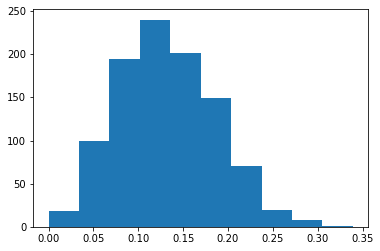

In [85]:
plt.hist(np.array(a))

In [68]:
a=[nConflicts2(freeMutate(approxAssignment(8),8),8) for _ in range(100)]

[(6, 4), (7, 3), (5, 1), (8, 2)] 0
[(1, 3), (6, 5), (8, 4), (2, 7)] 0
[(5, 2), (7, 4), (8, 6), (3, 1)] 0
[(8, 3), (6, 7), (2, 4), (1, 5)] 0
[(4, 7), (2, 6), (1, 8), (5, 3)] 0
[(1, 2), (8, 5), (6, 3), (8, 7)] 1
[(5, 7), (2, 3), (4, 1), (6, 8)] 0
[(3, 6), (7, 5), (1, 4), (2, 8)] 0
[(2, 5), (1, 7), (4, 6), (3, 8)] 0
[(5, 6), (3, 2), (4, 8), (7, 1)] 0
[(7, 2), (3, 4), (6, 1), (3, 4)] 2
[(3, 7), (6, 2), (8, 1), (5, 4)] 0
[(4, 2), (1, 6), (5, 8), (7, 8)] 1
[(3, 5), (2, 1), (7, 6), (4, 3)] 1
1
[(4, 1), (3, 2), (5, 6), (7, 8)] 0
[(5, 3), (8, 7), (4, 2), (1, 6)] 0
[(8, 5), (6, 3), (2, 7), (1, 4)] 0
[(2, 3), (1, 5), (8, 4), (6, 7)] 0
[(5, 8), (3, 1), (4, 6), (7, 2)] 0
[(1, 7), (3, 4), (8, 6), (2, 5)] 0
[(7, 6), (3, 8), (5, 4), (2, 1)] 0
[(2, 6), (7, 1), (5, 3), (2, 4)] 1
[(6, 4), (3, 5), (1, 8), (6, 2)] 1
[(5, 7), (3, 6), (2, 8), (8, 3)] 2
[(7, 5), (1, 2), (6, 8), (8, 2)] 2
[(8, 1), (4, 5), (7, 3), (6, 5)] 1
[(5, 1), (3, 7), (4, 8), (4, 7)] 2
[(5, 2), (7, 4), (6, 1), (1, 3)] 1
1
[(7, 5), (4, 3),

[(1, 2), (5, 4), (7, 6), (3, 8)] 0
[(6, 5), (1, 7), (2, 3), (8, 4)] 0
[(7, 3), (1, 8), (6, 4), (5, 2)] 0
[(5, 7), (2, 1), (3, 6), (4, 1)] 1
[(4, 3), (7, 8), (2, 6), (7, 5)] 1
1
[(1, 4), (3, 6), (7, 8), (2, 5)] 0
[(1, 2), (7, 6), (4, 8), (5, 3)] 0
[(6, 7), (1, 5), (3, 8), (2, 4)] 0
[(5, 1), (3, 4), (2, 6), (8, 7)] 0
[(2, 7), (1, 6), (8, 4), (3, 5)] 0
[(6, 4), (5, 2), (1, 8), (7, 3)] 0
[(6, 2), (1, 3), (5, 4), (7, 5)] 1
[(4, 1), (7, 2), (8, 6), (6, 3)] 1
[(8, 2), (5, 6), (4, 7), (3, 1)] 0
[(8, 5), (2, 3), (1, 7), (5, 8)] 2
[(6, 5), (7, 1), (4, 3), (2, 8)] 0
[(5, 7), (8, 1), (3, 2), (4, 5)] 1
[(6, 8), (2, 1), (3, 7), (4, 2)] 1
[(8, 3), (7, 4), (6, 1), (5, 8)] 1
1
[(2, 5), (4, 8), (1, 3), (6, 7)] 0
[(7, 2), (1, 6), (3, 4), (8, 5)] 0
[(5, 8), (6, 4), (1, 7), (3, 2)] 0
[(6, 1), (7, 8), (4, 3), (5, 2)] 0
[(6, 3), (2, 8), (4, 1), (7, 5)] 0
[(6, 5), (2, 4), (3, 7), (8, 1)] 0
[(2, 7), (5, 4), (3, 6), (1, 8)] 0
[(1, 2), (3, 5), (8, 4), (2, 3)] 2
[(2, 3), (1, 5), (8, 7), (4, 6)] 0
[(8, 2), (7, 3),

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

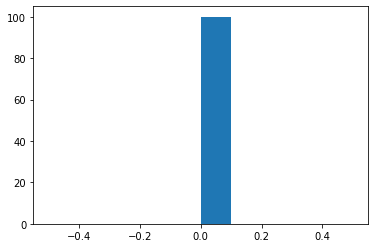

In [57]:
plt.hist(a)

In [49]:
np.array(a).min()

0.16666666666666666

In [42]:
p=randomAssignment(4)
p

[(4, 2),
 (2, 1),
 (1, 3),
 (3, 2),
 (3, 1),
 (4, 1),
 (3, 4),
 (2, 4),
 (4, 3),
 (1, 2),
 (1, 4),
 (2, 3)]

In [43]:
nConflicts2(p,4)

[(4, 2), (2, 1)] 1
[(1, 3), (3, 2)] 1
[(3, 1), (4, 1)] 1
[(3, 4), (2, 4)] 1
[(4, 3), (1, 2)] 0
[(1, 4), (2, 3)] 0


0.3333333333333333

In [16]:
for i in range(100):
    p=randomAssignment(8)
    if nConflicts(p,8)!=nConflicts2(p,8):
        pass
        #print(i,nConflicts(p,8),nConflicts2(p,8))

[[4, 3],
 [3, 4],
 [1, 3],
 [1, 2],
 [2, 4],
 [1, 4],
 [4, 2],
 [2, 3],
 [3, 2],
 [4, 1],
 [2, 1],
 [3, 1]]

In [19]:
a=conflicts(p,4)
n=4
for i in range(0,len(a),n//2):
        
        week=a[i:i+n//2]
        print(p[i:i+n//2],week,sum(week))

[4,3],[1,3],[3,4],[1,4],[3,1],[4,2],[3,2],[2,1],[4,1],[2,4],[1,2],[2,3],

In [18]:
p

[(4, 3),
 (1, 3),
 (3, 4),
 (1, 4),
 (3, 1),
 (4, 2),
 (3, 2),
 (2, 1),
 (4, 1),
 (2, 4),
 (1, 2),
 (2, 3)]

In [20]:
conflicts(p,4)

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]

In [78]:
# Returns the number of conflicts in an assignment. 
def nConflicts(assignment,nTeams):
    return sum(conflicts(assignment,nTeams))

## Min conflits (base line)

Para comparar el algo genetico con algo, intente implementar Min Conflicts (ver busqueda local en el lib) con swaps.

In [22]:
# Given the index of a conflict, return the game swap that results least nConflicts.
def minSwap(assignment,conflict,nTeams):
    bestN,bestOthers=None,[]
    for i in range(len(assignment)):
        assignment[conflict],assignment[i]=assignment[i],assignment[conflict]
        n=nConflicts(assignment,nTeams)
        if not bestN or n==bestN:
            bestN=n
            bestOthers.append(i)
        elif bestN and n<bestN:
            bestN=n
            bestOthers=[i]       
        assignment[conflict],assignment[i]=assignment[i],assignment[conflict]
    return random.choice(bestOthers)

In [23]:
# Returns the index of a random conflict in assignment.
def randomConflict(assignment,nTeams):
    indices=np.argwhere(conflicts(assignment,nTeams))
    return indices[np.random.randint(0,indices.shape[0])][0]

In [24]:
# Min Conflicts implementation.
# Returns final state of current and wether it was solved (nConflicts==0)
def minConflicts(nTeams,maxSteps,iniApprox=True,debug=False,autoEndK=100):
    current=approxAssignment(nTeams) if iniApprox else randomAssignment(nTeams)
    n=nConflicts(current,nTeams)
    lastK=[]
    for i in range(maxSteps):
        n=nConflicts(current,nTeams)
        lastK.append(n)
        lastK=lastK[-autoEndK:]
        if debug:print(n)
        if n==0 or (lastK and lastK.count(n)==autoEndK):break
        conflict=randomConflict(current,nTeams)
        other=minSwap(current,conflict,nTeams)
        current[conflict],current[other]=current[other],current[conflict]
    return current,i#i!=maxSteps-1

In [25]:
def kMinConflictsSolutions(n,k):
    solutions=[]
    avrgTime,avrgSteps,avrgResets=0,0,0
    maxSteps=n*15
    while len(solutions)<k:
        start=time.time()
        sol,steps=minConflicts(n,maxSteps,debug=False)
        t=time.time()-start
        if nConflicts(sol,n)==0:
            solutions.append(tuple(sol))
            avrgTime+=t
            avrgSteps+=steps
        else:
            avrgResets+=1
    return solutions,list(set(solutions)),avrgTime/k,avrgSteps/k,avrgResets/k,maxSteps

In [ ]:
for n in range(20,32,2):
    sols,unique,t,steps,resets,maxSteps=kMinConflictsSolutions(n,100)
    with open("minConflictsSols/"+str(n)+".json","w") as f:
        f.write(json.dumps(sols))
    print(n,len(unique),t,steps,resets,maxSteps)

In [ ]:
minConflicts(32,1000,debug=True)

In [ ]:
# Average nConflicts per nTeams of randomAssignment and 
n=6
s=0
print("n,avrRandom,avrApprox,Max,%avr rndom,%avrApprox")
for n in range(4,42,2):
    a=0
    s=0
    for i in range(100):
        s+=nConflicts(randomAssignment(n),n)
        a+=nConflicts(approxAssignment(n),n)
    print(','.join(map(str,[n,s/100,a/100,n*(n-1),(s/100)/(n*(n-1)),(a/100)/(n*(n-1))])))

## Genetic algo

Tenemos que definir operadores de mutacion y de reproduccion. Lo que se me ocurrio es que el de mutacion puede ser un swap aleatorio y el de cruzamiento.

In [28]:
def mutate(assignment):
    # Random swap
    i,j=np.random.choice(len(assignment),size=2,replace=False)
    assignment=assignment[:]
    assignment[i],assignment[j]=assignment[j],assignment[i]
    return assignment

In [66]:
def freeMutate(assignment,nTeams):
    a=assignment[:]
    k=random.randint(0,len(a)-1)
    a[k]=random.choice(games(nTeams))
    return a

In [30]:
def crossover(a,b):
    assert len(a)==len(b),"a and b must be same length"
    k=random.randint(0,len(a)) # Random crossover point
    #print(k)
    offspring1=a[:k]
    for game in b:
        if len(offspring1)==len(a):break
        if game not in offspring1:
            offspring1.append(game)
    
    #print(offspring1,len(offspring1))
    assert len(offspring1)==len(a)
    return offspring1

In [31]:
def freeCrossover(a,b):
    assert len(a)==len(b),"a and b must be same length"
    k=random.randint(0,len(a)) # Random crossover point
    offspring1=a[:k]+b[k:]
    offspring2=b[:k]+a[k:]
    assert len(offspring1)==len(a) and len(offspring2)==len(a)
    return offspring1,offspring2

In [32]:
def hamming(a,b):
    dist=0
    assert len(a)==len(b)
    for i in range(len(a)):
        if a[i]!=b[i]:
            dist+=1
    return dist

In [33]:
def hammingOfList(l):
    dist=0
    for i in range(len(l)):
        for j in range(i+1,len(l)):
            dist+=hamming(l[i],l[j])
    return dist

In [34]:
a=randomAssignment(5)
b=randomAssignment(5)

In [38]:
def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements 
    source: https://thispointer.com/python-how-to-find-all-indexes-of-an-item-in-a-list/
    '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
    return index_pos_list

def timeBetweenPairs(assignment,nTeams):
    dict_aux = {} 
    maxPossible = (len(assignment)/2)**2
    for i in range(1,nTeams+1):
        for j in range(i+1,nTeams+1):
            if i==j:continue                   
            inst_ord = get_index_positions(assignment, (i,j))
            inst_inv = get_index_positions(assignment, (j,i))            
            if len(inst_ord)>0 and len(inst_inv)>0:
                dict_aux[str((i,j))] = max(abs(max(inst_ord) - min(inst_inv)), abs(min(inst_ord) - max(inst_inv)))
            else: 
                # asigna el peor caso
                dict_aux[str((i,j))] = (maxPossible - sum(dict_aux.values())) / (len(assignment) - len(dict_aux))
    
                                        
    return (sum(dict_aux.values()) - 0.1*maxPossible)/maxPossible

MÁX - 0.9555555555555555: [(4, 3), (3, 2), (3, 1), (1, 4), (4, 2), (4, 3), (2, 1), (4, 1), (3, 4), (2, 4), (1, 3), (2, 3)]
MÍN - 0.20555555555555557: [(2, 3), (3, 2), (4, 3), (1, 3), (3, 4), (4, 1), (1, 4), (1, 3), (1, 2), (2, 4), (4, 2), (2, 4)]


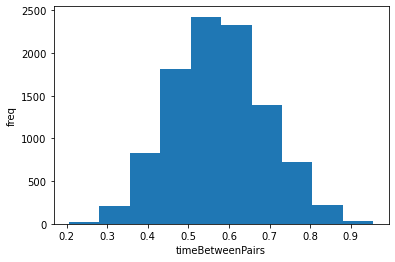

In [39]:
x = []
p_max = p_min = randomAssignment(4)
max_score = 0
min_score = 1
for _ in range(10000):
    r = randomAssignment(4)
    p = freeMutate(r,4)
    for i in range(random.randint(1, 9)):
        p = freeMutate(p,4)
    score = timeBetweenPairs(p,4)
    x.append(score)
    if score > max_score:
        p_max = p
        max_score = score
    if score < min_score:
        p_min = p
        min_score = score
    

plt.hist(x, density=False, bins=10)
plt.ylabel('freq')
plt.xlabel('timeBetweenPairs')

print("MÁX - " + str(max_score) + ": " + str(p_max))
print("MÍN - " + str(min_score) + ": " + str(p_min))

In [40]:
r=[(1, 4), (4, 3), (1, 2), (3, 2), (3, 1), (2, 1), (4, 3), (1, 3), (4, 1), (3, 4), (2, 3), (2, 4)]
timeBetweenPairs(r,4)

0.7576388888888889

In [41]:
r=randomAssignment(4)
r=freeMutate(r,4)
print(r)
timeBetweenPairs(r,4)

[(4, 3), (1, 4), (3, 4), (1, 2), (4, 1), (1, 3), (4, 1), (3, 1), (2, 1), (2, 3), (4, 2), (2, 4)]


0.39074074074074067

In [42]:
def alterningScore(assignment, nTeams):
    teams={str(i):[] for i in range(1,nTeams+1)}
    
    for game in assignment:
        teams[str(game[0])].append(0) # 0 if local
        teams[str(game[1])].append(1) # 1 if visiting
        
    # Average of scores
    return np.array([aux_score(team) for team in teams.values()]).mean() 

def aux_score(arr):
    s=0
    previous=arr[0]
    for i in range(1,len(arr)):
        if arr[i]!=previous:
            s+=1
        previous=arr[i]
    return (s-1)/(len(arr)-2)

In [43]:
# Returns the proportion of weeks in which a city has a game
# given a tournament assignment and the teams in that city.
def cityOccupied(assignment,teamsInCity,nTeams):
    weeks=0
    nOccupied=0
    teamsInCity=set(teamsInCity)
    n=nTeams
    for i in range(0,len(assignment),n//2):
        weeks+=1
        week=assignment[i:i+n//2]
        occupied=False
        for game in week:
            if game[0] in teamsInCity:
                occupied=True
                break
        if occupied:
            nOccupied+=1
    return nOccupied/weeks          

In [44]:
# Returns the average of cityOccupied() for every city.
def citiesAlwaysOccupied(assignment,cityTeams,nTeams):
    return np.array([cityOccupied(assignment,teamsInCity,nTeams) for teamsInCity in cityTeams.values()]).mean()

In [45]:
r=randomAssignment(4)
r

[(1, 3),
 (2, 4),
 (3, 4),
 (1, 2),
 (3, 1),
 (4, 2),
 (4, 1),
 (3, 2),
 (4, 3),
 (2, 1),
 (2, 3),
 (1, 4)]

In [46]:
distances=randomCityDistances(3)
distances

array([[33. , 26. , 53.5],
       [26. , 75. , 33. ],
       [53.5, 33. , 60. ]])

In [47]:
cityTeams=randomCityTeams(4,3)
cityTeams

{1: [4], 2: [3, 1], 3: [2]}

In [48]:
teamCity=teamToCity(cityTeams)

In [49]:
distanceTraveled(r,1,teamCity,distances)

NameError: name 'distanceTraveled' is not defined

In [50]:
# Returns the sum of the distance travelled by each team in an assignment
def totalDistanceTravelled(assignment,cityTeams,cityDistances,nTeams):
    teamsCity=teamToCity(cityTeams)
    return sum([distanceTraveled(assignment,team,teamsCity,cityDistances) for team in range(1,nTeams+1)])  

In [51]:
# Assumes a Traveling Tournament Problem (i.e. teams don't return home)
def distanceTraveled(assignment,team,teamsToCity,cityDistances):
    distance=0
    city=teamsToCity[team]
    # Asume start at home
    for game in assignment:
        if team==game[1]: # If plays as visitor
            otherCity=teamsToCity[game[0]]
            distance+=2*cityDistances[city-1][otherCity-1]
            city=otherCity
        elif team==game[0]:
            otherCity=teamCity[team] # Home city
            distance+=2*cityDistances[city-1][otherCity-1]
            city=otherCity
    return distance

In [52]:
# Fitness function with which to eval individuals and determine their survaival.
# At first, we will only consider the number of conflicts.
# We can then add other soft requirements
def fitness(individual,nTeams,cityTeams,weights=[0.85,0.05,0.05,0.05]):
    return -nConflicts(individual,nTeams)
    """"
    assert abs(sum(weights)-1)<1e-5,sum(weights)
    # Normalizing nConflicts. To minimize.
    conflicts=1-(nConflicts(individual,nTeams)/len(individual))
    
    # timeBetweenPair of teams score. Normalized. To maximize.
    pairTimes=timeBetweenPairs(individual,nTeams)
    
    # alterningScore. Normalized. To maximize.
    alterning=alterningScore(individual,nTeams)
    
    # citiesAlwaysOccupied score. Normalized. To maximize.
    citiesAlways=citiesAlwaysOccupied(individual,cityTeams,nTeams)
    
    #print(conflicts,pairTimes,alterning,citiesAlways)
    
    return (conflicts*weights[0]+pairTimes*weights[1]+alterning*weights[2]+citiesAlways*weights[3])
    """

In [53]:
def evolve(seed,debug=False):
    random.seed(seed)
    np.random.seed(seed)
    # Genetic algo
    nTeams=4
    cityTeams=randomCityTeams(nTeams,nTeams-1)
    n=300 #size of population
    nElite=int(n*0.05) #proportion best of population to retain
    k=0.70 # can regulate "temperature"
    mutationRate=0.1 # rate at which to mutate individuals
    assert n%2==0,'N must be even to crossover'
    # Random inicialitation of population
    population=[approxAssignment(nTeams) for i in range(n)]
    scores=[fitness(ind,nTeams,cityTeams) for ind in population]
    gen=0
    didntImprove=0
    didntImproveMax=250
    lastMax=None
    while True:
        
        # SELECTION (Investigate other methods)
        # Elitist -> choose best n
        elite=sorted(population,key=lambda x:fitness(x,nTeams,cityTeams),reverse=True)[:nElite]

        # Tournament with remaining n-nElite
        fromTournament=[]
        for _ in range(n-nElite):
            a,b=np.random.choice(n,size=2,replace=False)
            best,worst=(a,b) if fitness(population[a],nTeams,cityTeams)>fitness(population[b],nTeams,cityTeams) else (b,a)
            if random.random()<k:
                fromTournament.append(population[best])
            else:
                fromTournament.append(population[worst])

        # CROSSOVER -> according to fitness
        population=[]
        for _ in range(n-nElite):
            a,b=np.random.choice(len(fromTournament),size=2,replace=False)
            population.append(freeCrossover(fromTournament[a],fromTournament[b])[0])

        # MUTATION
        for i in range(len(population)):
            if random.random()<mutationRate:
                population[i]=freeMutate(population[i],nTeams)

        #Add elite
        population=elite+population
        assert len(population)==n

        # LOGGING
        scores=np.array([fitness(ind,nTeams,cityTeams) for ind in population])
        conf=np.array([nConflicts(ind,nTeams) for ind in population])
        #print(','.join([str(int(i)) for i in scores]),np.array(scores).mean())
        if debug:
            print(gen,k,scores.mean(),scores.min(),scores.max(),(np.array(scores)==0).sum(),'didnt',didntImprove,(conf==0).sum())

        # STOPPING CRITIREA -> if 90% of population are valid sols. (Change later)
        if not lastMax or scores.max()>lastMax:
            lastMax=scores.max()
            didntImprove=0
        else:
            didntImprove+=1

        if didntImprove>=didntImproveMax:
            break
        gen+=1

    return gen,scores.mean(),scores.min(),scores.max(),(np.array(scores)==0).sum(),population

In [54]:
def uniqueSolutions(population):
    unique=set()
    for i in population:
        if nConflicts(i,nTeams)==0:
            unique.add(tuple(i))
    return unique

In [ ]:
for i in range(10):
    gen,mean,_min,_max,valid,population=evolve(seed=i,debug=True)
    uniqueSols=len(uniqueSolutions(population))
    print(gen,mean,_min,_max,valid,uniqueSols)
    break

In [ ]:
[[(1, 4), (2, 3), (5, 7), (6, 8), (3, 4), (6, 5), (8, 1), (2, 7), (7, 1), (3, 6), (8, 5), (4, 2), (3, 7), (5, 2), (4, 8), (1, 6), (3, 1), (7, 2), (6, 4), (5, 8), (2, 8), (4, 5), (7, 6), (1, 3), (2, 5), (3, 8), (4, 7), (6, 1), (4, 6), (8, 3), (1, 7), (7, 5), (4, 1), (8, 7), (2, 6), (5, 3), (8, 2), (3, 5), (7, 4), (1, 8), (6, 2), (8, 4), (7, 3), (5, 1), (6, 7), (1, 5), (4, 3), (2, 1), (1, 2), (5, 6), (7, 8), (2, 4), (5, 4), (3, 2), (8, 6), (6, 3)], [(5, 2), (7, 1), (4, 8), (3, 6), (4, 5), (3, 2), (6, 1), (8, 7), (8, 3), (6, 7), (1, 4), (2, 5), (7, 3), (8, 6), (2, 4), (1, 5), (6, 5), (4, 1), (3, 8), (2, 7), (5, 6), (1, 3), (7, 2), (8, 4), (5, 8), (4, 7), (2, 6), (3, 1), (2, 8), (5, 7), (3, 4), (1, 6), (5, 4), (7, 8), (6, 2), (2, 3), (4, 6), (1, 8), (3, 7), (6, 3), (8, 1), (7, 5), (4, 3), (3, 5), (2, 1), (7, 6), (8, 5), (1, 7), (1, 2), (5, 3), (6, 4), (5, 1), (8, 2), (7, 4), (6, 8), (4, 2)]]

In [ ]:
unique=set()
for i in population:
    if nConflicts(i,nTeams)==0:
        unique.add(tuple(i))

In [ ]:
len(unique)

In [ ]:
for i in unique:
    print(i)
    for team in teamsInGames(list(i)):
        if teamsInGames(list(i)).count(team)!=nTeams:
            print(team,teamsInGames(list(i)).count(team),len(i))
    print()